## Optimal_Shelter_Location_Selection

세종시 무더위 쉼터 최적 위치 선정

# Module Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium
import requests
import json
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Load

In [ ]:
bus_stops = pd.read_csv('/content/drive/MyDrive/무더위쉼터/세종_버스정류장_시설현황.csv')
data = pd.read_csv('/content/drive/MyDrive/무더위쉼터/data.csv')

##### 버스 정류장 수 추가

In [ ]:
# GeoJSON 파일 로드
r = requests.get('https://raw.githubusercontent.com/raqoon886/Local_HangJeongDong/master/hangjeongdong_%EC%84%B8%EC%A2%85%ED%8A%B9%EB%B3%84%EC%9E%90%EC%B9%98%EC%8B%9C.geojson')
c = r.content
sejong_geo = json.loads(c)

# GeoDataFrame으로 변환
gdf = gpd.GeoDataFrame.from_features(sejong_geo['features'])

# 버스 정류장 데이터를 GeoDataFrame으로 변환
gdf_bus_stops = gpd.GeoDataFrame(
    bus_stops,
    geometry=gpd.points_from_xy(bus_stops['경도'], bus_stops['위도']),
    crs="EPSG:4326"  # 위도와 경도의 좌표 체계
)

# 지역구(adm_cd)를 포함하는 세종시 행정구역 GeoDataFrame과 버스 정류장 GeoDataFrame을 공간적으로 결합
matched = gpd.sjoin(gdf_bus_stops, gdf, how="left", op="within")
result = matched[['정류소명', 'adm_nm', '위도', '경도']]

# 'adm_nm' 컬럼에서 '세종특별자치시 세종시' 문자열 제거
result['adm_nm'] = result['adm_nm'].str.replace('세종특별자치시 세종시 ', '')

# 'adm_nm' 컬럼의 값별 빈도수 계산
adm_nm_counts = result['adm_nm'].value_counts()

# 빈도수를 'adm_nm' 컬럼 값에 매핑하여 새 컬럼에 추가
result['adm_nm_count'] = result['adm_nm'].map(adm_nm_counts)

adm_nm_counts = result['adm_nm'].value_counts().reset_index()
adm_nm_counts.columns = ['지역', '정류장수']

##### 지표면 온도 값 추가

In [ ]:
temperature_locations = [
    [36.497871, 127.237767],
    [36.470459, 127.252364],
    [36.471890, 127.271823],
    [36.481128, 127.266374],
    [36.486631, 127.266701],
    [36.496334, 127.278489],
    [36.493913, 127.289891],
    [36.501689, 127.293434],
    [36.502097, 127.264741],
    [36.506596, 127.258061],
    [36.508146, 127.232931],
    [36.517452, 127.229018],
    [36.547214, 127.269891],
    [36.496909, 127.363953]
]

temperature_df = pd.DataFrame(temperature_locations, columns=['위도', '경도'])

temperature_locations_gdf = gpd.GeoDataFrame(
    temperature_locations,
    geometry=gpd.points_from_xy([loc[1] for loc in temperature_locations], [loc[0] for loc in temperature_locations]),
    crs="EPSG:4326"
)

matched_temperature = gpd.sjoin(temperature_locations_gdf, gdf, how="left", op="within")


matched_temperature['adm_nm'] = matched_temperature['adm_nm'].str.replace('세종특별자치시 세종시 ', '')


temperature_adm_nm_counts = matched_temperature['adm_nm'].value_counts().reset_index()
temperature_adm_nm_counts.columns = ['지역', '35도이상']

In [ ]:
merged_df = pd.merge(temperature_adm_nm_counts, data, on='지역', how='outer')
final_merged_df = pd.merge(merged_df, adm_nm_counts, on='지역', how='outer')

final_merged_df.drop(columns=['Unnamed: 4'], inplace=True)
final_merged_df.fillna(0, inplace=True)

data = final_merged_df

In [ ]:
print(data.shape)
data.head()

# Missing Value Check

In [ ]:
data.info()

In [ ]:
data.isnull().sum() / data.shape[0]

# Visualization

##### 지표면 온도

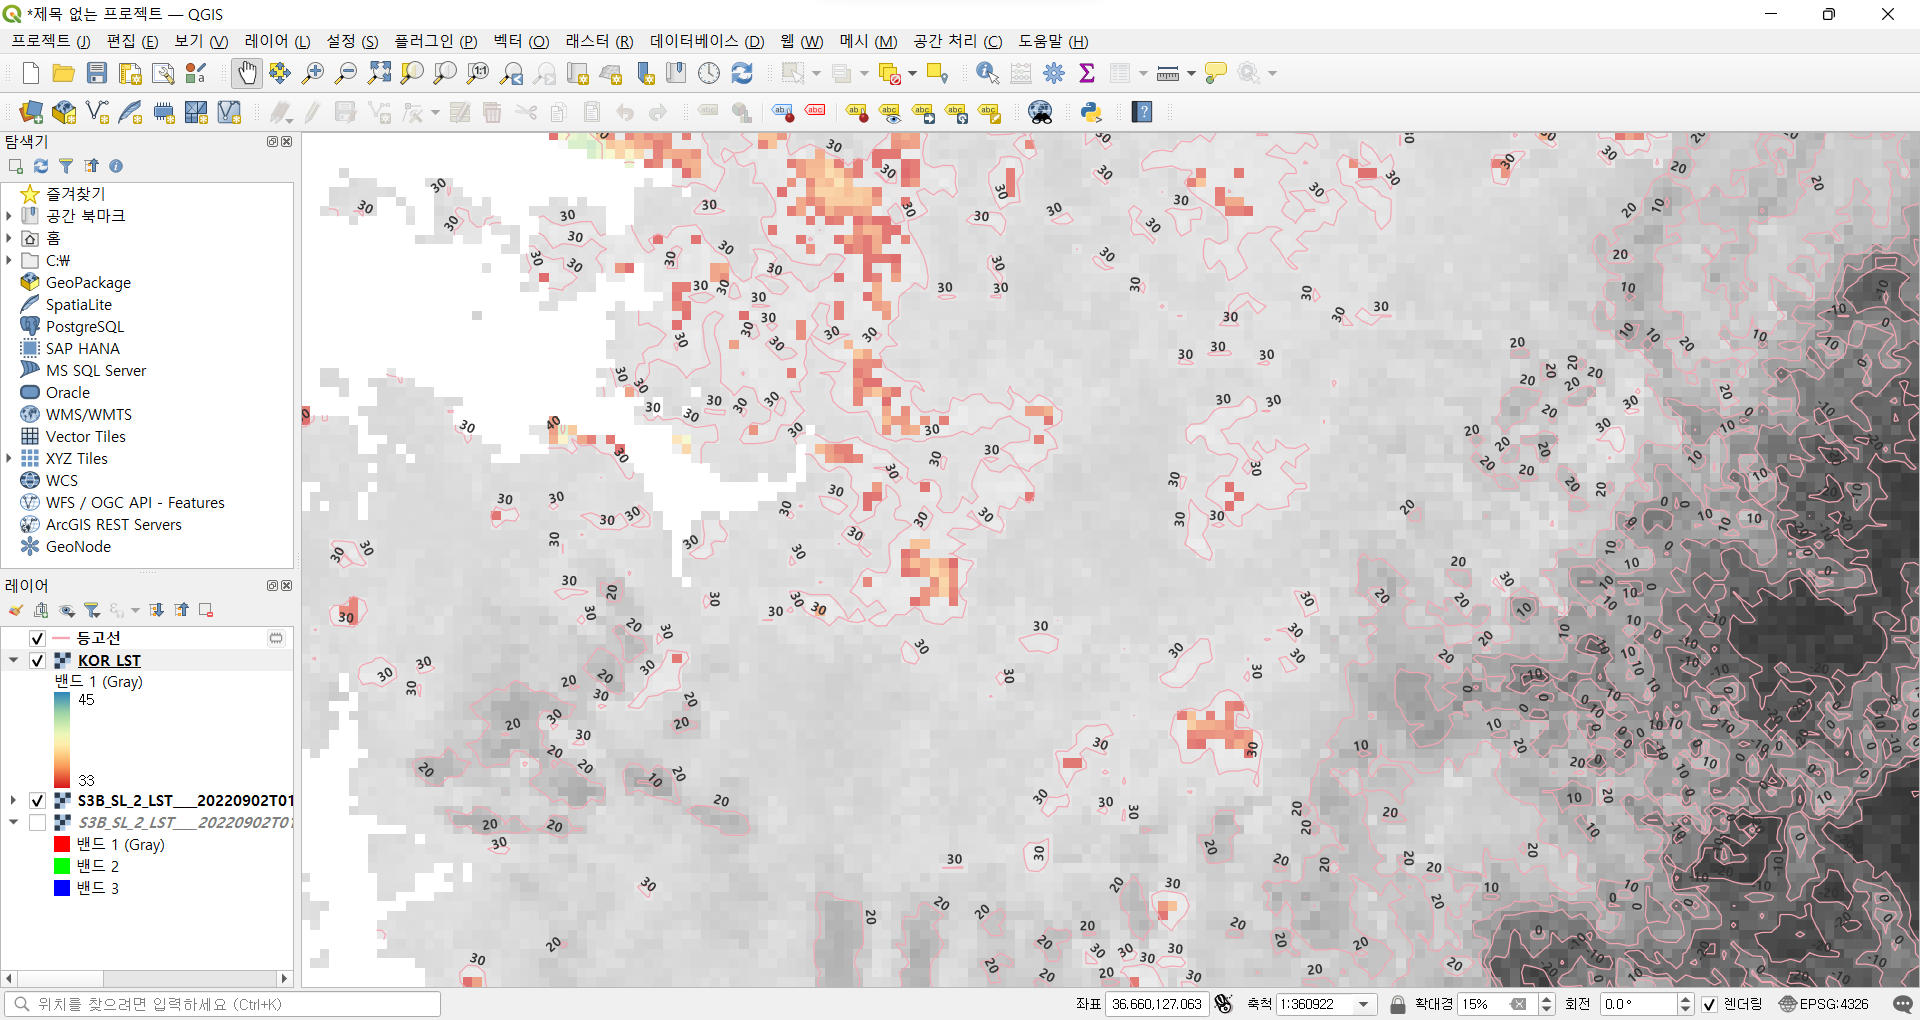

In [ ]:
# 지도 중심을 버스 정류장 위치의 평균으로 설정
map_center = [bus_stops['위도'].mean(), bus_stops['경도'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# 온도 이상 지역에 빨간색 마커 추가
for location in temperature_locations:
    folium.CircleMarker(
        location=location,
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        popup='온도 이상 지역',
        tooltip='온도 이상 지역'
    ).add_to(m)

# 버스 정류장 위치에 파란색 마커 추가
for index, row in bus_stops.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue',
        popup=row['정류소명'],
        tooltip=row['정류소명']
    ).add_to(m)

# 세종시 행정구역 경계 추가
sejong_geo = json.loads(requests.get('https://raw.githubusercontent.com/raqoon886/Local_HangJeongDong/master/hangjeongdong_%EC%84%B8%EC%A2%85%ED%8A%B9%EB%B3%84%EC%9E%90%EC%B9%98%EC%8B%9C.geojson').content)
folium.GeoJson(sejong_geo, name='지역구').add_to(m)

# 지도 저장
m.save('optimal_shelter_map.html')
m


# Correlation Visualize

In [ ]:
# 한글
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic') #폰트를 나눔 고딕 폰트로 지정

In [ ]:
# 상관관계 매트릭스 계산
corr_matrix = data.corr()

# 상관관계 매트릭스 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# 회귀분석

In [ ]:
df = data


df["35도이상_비율"] = df["35도이상"] / df["35도이상"].sum()
df["노인인구_비율"] = df["인구수"] / df["지역"].apply(lambda x: len(x))
df["복지시설_비율"] = df["노인복지시설"] / df["인구수"]
df["교통_비율"] = df["정류장수"] / df["지역"].apply(lambda x: len(x))

variables = ["35도이상_비율", "노인인구_비율", "복지시설_비율", "교통_비율"]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(df[variables], df["인구수"], test_size=0.2, random_state=42)

# 회귀 모델 생성
model = LinearRegression()
model.fit(X_train, y_train)

# 회귀 계수 확인
coefficients = model.coef_

# 새로운 종합평가 컬럼 생성
df['종합_평가'] = df[variables].dot(coefficients)

In [ ]:
import matplotlib.pyplot as plt

# 맵 시각화
plt.figure(figsize=(10, 8))  # 그래프 크기 조절
plt.scatter(df["지역"], df["종합_평가"])
plt.xlabel("지역")
plt.ylabel("종합 평가")
plt.xticks(rotation=45)  # x축 레이블을 45도 기울여서 표시
plt.show()

# 그래프 시각화
plt.figure(figsize=(10, 8))  # 그래프 크기 조절
plt.bar(df["지역"], df["종합_평가"])
plt.xlabel("지역")
plt.ylabel("종합 평가")
plt.xticks(rotation=45)  # x축 레이블을 45도 기울여서 표시
plt.show()


# K-means 군집분석

##### Elbow Graph

In [ ]:
# cluster_range = range(1, 11)

# number_of_clusters = []
# cluster_errors = []

# for k in cluster_range:
#   kmeans = KMeans(n_clusters=k)
#   kmeans.fit(df_x)
#   cluster_errors.append(kmeans.inertia_)
#   number_of_clusters.append(k)

# data1 = {'Number of Clusters': number_of_clusters, 'Error': cluster_errors}
# df_error = pd.DataFrame(data1)

# plt.figure(figsize=(10, 5))
# plt.plot(df_error['Number of Clusters'], df_error['Error'])
# plt.title('Sum of Squared Distance')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Sum of Squared Distance')
# plt.show()

# Data Preprocessing - Normalize

In [ ]:
# x = data.drop(["지역"], axis=1) # 독립변인 추출

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# df_x = scaler.fit_transform(x) # 설명변수